# SVM
*** Date: 2019-1-5 ***

*** Author:wwt117@163.com ***

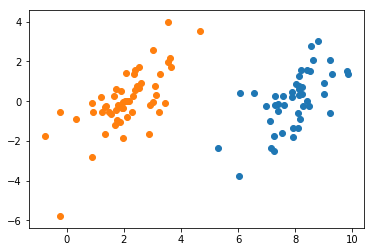

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
import random
import types

def LoadData(fileName):
    """
    Load the dataset and plot the figure
    :param fileName - the name(path) of the data file
    """
    # Open the file
    f = open(fileName)
    
    data = []
    label = []
    
    # Read the data and corresponding labels by lines
    for line in f.readlines():
        temp = line.strip().split('\t')
        data.append([float(temp[0]),float(temp[1])])
        label.append(float(temp[2]))
         
    c1 = []
    c2 = []                 
                     
    # Classify the data to different group                     
    for i in range(len(data)):
        if label[i] > 0:
            c1.append(data[i])
        else:
            c2.append(data[i])
    C1 = np.array(c1)
    C2 = np.array(c2)       
    
    # Visualize the dataset    
    plt.scatter(C1.T[0], C1.T[1])   
    plt.scatter(C2.T[0], C2.T[1]) 
    plt.show()
  
    return data,label

                    
data,label = LoadData('dataset.txt')


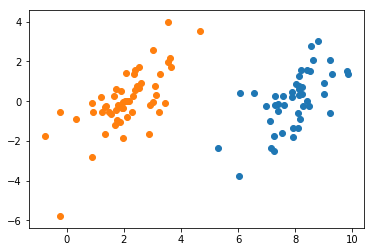

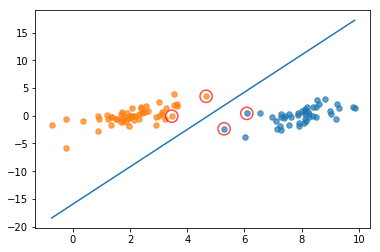

In [3]:
# The simple version of SMO

def clipAlpha(alpha,H,L):
    """
    limit the bound of alpha
    """
    if alpha > H:
        alpha = H
    if L > alpha:
        alpha = L
    return alpha



def selectJrand(i,m):
    """
    randomly select a number j, which is different from i
    """
    j = i
    while(j==i):
        j = int(random.uniform(0,m))
    return j

def SmoSimple(data,label,C,toler,iter_max):
    """
    A simple version of smo algorithm
    """
    # convert list to mat
    dataMat = np.mat(data)
    labelMat = np.mat(label).T
    # The demension of the matrix 'data'
    row,col = np.shape(data)
    # Initialize the parameter 'b' 'alphas' 
    b = 0
    alphas = np.mat(np.zeros((row,1)))
    # the initial iteration number
    iter_num = 0
    # smo algorithm
    while(iter_num < iter_max):
        alphaPairsChanged = 0     
        for i in range(row):
            # compute the error Ei between yi and f(xi)
            fxi = float(np.multiply(alphas,labelMat).T * (dataMat * dataMat[i,:].T)) + b # 这里的矩阵乘法中选择每次一个数据(这里使用矩阵乘法来计算累加和)
            Ei = fxi - float(labelMat[i])          
            # first select a alpha_i, optimize the alpha_i, tolerant with a parameter 'toler'(这里是找不满足KKT条件的alpha)
            if((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                # randomly select another alpha_j
                j = selectJrand(i,row)            
                # compute the error Ej between yj and f(xj)
                fxj = float(np.multiply(alphas,labelMat).T * (dataMat * dataMat[j,:].T)) + b 
                Ej = fxj - float(labelMat[j]);           
                # save the current alpha value
                alpha_i_old = alphas[i].copy()
                alpha_j_old = alphas[j].copy()         
                # compute the upper bound and low bound
                if(labelMat[i]!=labelMat[j]):
                    L = max(0,alphas[j] - alphas[i])
                    H = min(C,C + alphas[j] - alphas[i])
                else:
                    L = max(0,alphas[j] + alphas[i] - C)
                    H = min(C,alphas[j] + alphas[i])
                if L==H:
          #          print("L==H")
                    continue          
                # compute the yita
                eta = 2.0 * dataMat[i,:] * dataMat[j,:].T - dataMat[i,:] * dataMat[i,:].T - dataMat[j,:] * dataMat[j,:].T
                if eta >=0:
         #           print("yita>=0")
                    continue      
                # update the alpha_j
                alphas[j] -= labelMat[j] * (Ei - Ej) / eta         
                # limit the bound of alpha_j
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alpha_j_old)<0.00001):
             #       print("The change of the alpha_i is too small!")
                    continue  
                # update the alpha_i
                alphas[i] += labelMat[j] * labelMat[i] * (alpha_j_old - alphas[j])
                # update the b1 and b2
                b1 = b - Ei - labelMat[i] * (alphas[i] - alpha_i_old) * dataMat[i,:] * dataMat[i,:].T - labelMat[j] * (alphas[j] - alpha_j_old) * dataMat[i,:] * dataMat[j,:].T
                b2 = b - Ej - labelMat[i] * (alphas[i] - alpha_i_old) * dataMat[i,:] * dataMat[j,:].T - labelMat[j] * (alphas[j] - alpha_j_old) * dataMat[j,:] * dataMat[j,:].T        
                # update the b according to b1 and b2
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2) / 2.0                 
                # cal the number of alpha optimization
                alphaPairsChanged +=1 
        #        print("The %dth iteration sample %d, number of alpha optimization:%d"% (iter_num,i,alphaPairsChanged) )
        # update the iteration number
        if (alphaPairsChanged ==0):
            iter_num += 1
        else:
            iter_num = 0
      #  print("The number of iteration: %d" % iter_num)  
    return b,alphas
    
def calW(dataMat,labelMat,alphas):
    """
    compute the parameter 'w'
    """
    alphas, dataMat, labelMat = np.array(alphas), np.array(dataMat), np.array(labelMat)
    w = np.dot((np.tile(labelMat.reshape(1, -1).T, (1, 2)) * dataMat).T, alphas)
    return w.tolist()

def visualize(data, label, w, b):
    """
    plot the smaples and the svm classifier
    """
    # the positive and negetive group
    c1 = []
    c2 = []                 
                     
    # Classify the data to different group                     
    for i in range(len(data)):
        if label[i] > 0:
            c1.append(data[i])
        else:
            c2.append(data[i])
    C1 = np.array(c1)
    C2 = np.array(c2)       
    
    # Visualize the dataset    
    plt.scatter(C1.T[0], C1.T[1], s=30, alpha=0.7)   
    plt.scatter(C2.T[0], C2.T[1], s=30, alpha=0.7) 
    
    # plot the classifer line
    x1 = max(data)[0]
    x2 = min(data)[0]

    a1,a2 = w
    b = float(b)
    a1 = float(a1[0])
    a2 = float(a2[0])
    y1,y2 = (-b-a1*x1)/a2, (-b-a1*x2)/a2
    plt.plot([x1,x2],[y1,y2])
    
    # plot the support vector 
    for i, alpha in enumerate(alphas):
        if abs(alpha) > 0:
            x, y = data[i]
            plt.scatter([x], [y], s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='red')
    plt.show()


if __name__ == '__main__':
    dataMat, labelMat = LoadData('dataset.txt')
    b,alphas = SmoSimple(dataMat, labelMat, 0.6, 0.001, 40)
    w = calW(dataMat, labelMat, alphas)
    visualize(dataMat, labelMat, w, b)

                

全样本遍历：第0次迭代 样本:0,alpha优化次数:1
全样本遍历：第0次迭代 样本:1,alpha优化次数:1
eta>=0
全样本遍历：第0次迭代 样本:2,alpha优化次数:1
全样本遍历：第0次迭代 样本:3,alpha优化次数:2
eta>=0
全样本遍历：第0次迭代 样本:4,alpha优化次数:2
eta>=0
全样本遍历：第0次迭代 样本:5,alpha优化次数:2
eta>=0
全样本遍历：第0次迭代 样本:6,alpha优化次数:2
全样本遍历：第0次迭代 样本:7,alpha优化次数:2
全样本遍历：第0次迭代 样本:8,alpha优化次数:2
全样本遍历：第0次迭代 样本:9,alpha优化次数:2
全样本遍历：第0次迭代 样本:10,alpha优化次数:3
全样本遍历：第0次迭代 样本:11,alpha优化次数:3
全样本遍历：第0次迭代 样本:12,alpha优化次数:3
L==H
全样本遍历：第0次迭代 样本:13,alpha优化次数:3
全样本遍历：第0次迭代 样本:14,alpha优化次数:3
eta>=0
全样本遍历：第0次迭代 样本:15,alpha优化次数:3
L==H
全样本遍历：第0次迭代 样本:16,alpha优化次数:3
全样本遍历：第0次迭代 样本:17,alpha优化次数:3
eta>=0
全样本遍历：第0次迭代 样本:18,alpha优化次数:3
全样本遍历：第0次迭代 样本:19,alpha优化次数:3
全样本遍历：第0次迭代 样本:20,alpha优化次数:3
全样本遍历：第0次迭代 样本:21,alpha优化次数:3
eta>=0
全样本遍历：第0次迭代 样本:22,alpha优化次数:3
全样本遍历：第0次迭代 样本:23,alpha优化次数:4
全样本遍历：第0次迭代 样本:24,alpha优化次数:4
L==H
全样本遍历：第0次迭代 样本:25,alpha优化次数:4
L==H
全样本遍历：第0次迭代 样本:26,alpha优化次数:4
全样本遍历：第0次迭代 样本:27,alpha优化次数:4
全样本遍历：第0次迭代 样本:28,alpha优化次数:4
eta>=0
全样本遍历：第0次迭代 样本:29,alpha优化次数:4
全样本遍历：第0次迭代 样本:30,alpha优化次数:4
L==H

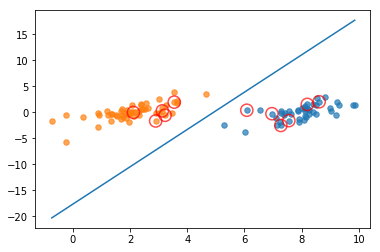

In [45]:
# The complete version of SMO
import matplotlib.pyplot as plt
import numpy as np
import random

class optStruct:
    def __init__(self,data,label,C,toler):
        self.X = data  # data
        self.labelMat = label # label
        self.C = C # slack value            
        self.tol = toler # tolerant
        self.m = np.shape(data)[0] # the row of the data 
        self.alphas = np.mat(np.zeros((self.m,1))) # alpha 
        self.b = 0 # bias
        self.eCache = np.mat(np.zeros((self.m,2)))
                                             
def LoadData(fileName):
    """
    read the data file
    """
    data = []
    label = []
    fr = open(fileName)
    for line in fr.readlines():
        temp = line.strip().split('\t')
        data.append([float(temp[0]),float(temp[1])])
        label.append(float(temp[2]))
    return data,label


                             
                             
def calcEk(oS,k):
    """
    compute the error 'Ek'
    """
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*(oS.X*oS.X[k,:].T)+oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

def clipAlpha(alpha,H,L):
    """
    limit the bound of alpha
    """
    if alpha > H:
        alpha = H
    if L > alpha:
        alpha = L
    return alpha

def updateEk(oS, k):
    """
    a list that save the temporary error
    """
    Ek = calcEk(oS, k)                                      
    oS.eCache[k] = [1,Ek]                                   


def selectJrand(i,m):
    """
    randomly select a number j, which is different from i
    """
    j = i
    while(j==i):
        j = int(random.uniform(0,m))
    return j

def selectJ(i,oS,Ei):
    """
    A heuristics way to select alpha
    """
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1,Ei]
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:
            if k==i:
                continue
            Ek = calcEk(oS,k)
            deltaE = abs(Ei - Ek)
            if(deltaE>maxDeltaE):
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK,Ej
    else:
        j = selectJrand(i,oS.m)
        Ej = calcEk(oS,j)
    return j,Ej
    
    
def innerL(i,oS):
    """
    the optimization of smo algorithm
    """
    # compute the error Ei
    Ei = calcEk(oS,i)
    
    # opt the alpha with a tolerant C
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        
        # using the heuristics way to select a alpha_j and cal the Ej
        j,Ej = selectJ(i,oS,Ei)
        
        # save the alphas
        alpha_i_old = oS.alphas[i].copy(); alpha_j_old = oS.alphas[j].copy();

        # compute the upper bound and low bound
        if(oS.labelMat[i]!=oS.labelMat[j]):
            L = max(0,oS.alphas[j] - oS.alphas[i])
            H = min(oS.C,oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0,oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C,oS.alphas[j] + oS.alphas[i])
        if L==H:
            print("L==H")
            return 0    
    
        # compute the yite
        eta = 2.0 * oS.X[i,:] * oS.X[i,:].T - oS.X[i,:] * oS.X[i,:].T - oS.X[j,:] * oS.X[j,:].T
        if eta >= 0:
            print("eta>=0")
            return 0
        
        # update alpha_j
        oS.alphas[j] -= oS.labelMat[j] * (Ei -Ej) / eta
        
        # limit the bound of alpha_j
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        
        # update Ej and save it to error list
        updateEk(oS,j)
        if(abs(oS.alphas[j] - alpha_j_old)<0.00001):
            print("alpha_j变化太小")
            return 0
        
        # update the alpha_i
        oS.alphas[i] += oS.labelMat[j] * oS.labelMat[i] * (alpha_j_old - oS.alphas[j])
    
        # update the Ei and save it to error list
        updateEk(oS,i)

        # update b1 and b2
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alpha_i_old)*oS.X[i,:]*oS.X[i,:].T - oS.labelMat[j]*(oS.alphas[j]-alpha_j_old)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alpha_i_old)*oS.X[i,:]*oS.X[j,:].T - oS.labelMat[j]*(oS.alphas[j]-alpha_j_old)*oS.X[j,:]*oS.X[j,:].T
       
        # update the b
        if(0 < oS.alphas[i]) and (oS.C > oS.alphas[i]):
            oS.b = b1
        elif(0 < oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2 ) / 2
        return 1
    else:
        return 0

def smoComplete(data,label,C,toler,iter_max):
    """
    the complete smo algorithm
    """
    oS = optStruct(np.mat(data),np.mat(label).T,C,toler)
    iter = 0
    entireSet = True
    alphaPairsChanged = 0
    while (iter < iter_max) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerL(i,oS)
                print("全样本遍历：第%d次迭代 样本:%d,alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:
            nonBoundIs = np.nonzero((oS.alphas.A>0)*(oS.alphas.A<C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("非边界遍历：第%d次迭代 样本:%d,alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet:
            entireSet = False
        elif (alphaPairsChanged==0):
            entireSet = True
        print("迭代次数:%d" % iter)
    return oS.b,oS.alphas



def visualize(data, label, w, b):
    """
    plot the smaples and the svm classifier
    """
    # the positive and negetive group
    c1 = []
    c2 = []                 
                     
    # Classify the data to different group                     
    for i in range(len(data)):
        if label[i] > 0:
            c1.append(data[i])
        else:
            c2.append(data[i])
    C1 = np.array(c1)
    C2 = np.array(c2)       
    
    # Visualize the dataset    
    plt.scatter(C1.T[0], C1.T[1], s=30, alpha=0.7)   
    plt.scatter(C2.T[0], C2.T[1], s=30, alpha=0.7) 
    
    # plot the classifer line
    x1 = max(data)[0]
    x2 = min(data)[0]

    a1,a2 = w
    b = float(b)
    a1 = float(a1[0])
    a2 = float(a2[0])
    y1,y2 = (-b-a1*x1)/a2, (-b-a1*x2)/a2
    plt.plot([x1,x2],[y1,y2])
    
    # plot the support vector 
    for i, alpha in enumerate(alphas):
        if abs(alpha) > 0:
            x, y = dataMat[i]
            plt.scatter([x], [y], s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='red')
    plt.show()
            
           
def calW(alphas,data,label):
    """
    compute the parameter 'w'
    """
    X = np.mat(data)
    labelMat = np.mat(label).T
    m,n = np.shape(X)
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w
   
if __name__ == '__main__':
    dataArr, classLabels = LoadData('dataset.txt')
    b, alphas = smoComplete(dataArr, classLabels, 0.6, 0.001, 40)
    w = calW(alphas,dataArr, classLabels)
    visualize(dataArr, classLabels, w, b)
